Starting Watermarking Analysis...
Host images: results/host/image1.jpg to image10.jpg
Watermark: results/watermark_32x32.png
Output directory: results/analysis/

=== Analyzing Image 1 ===
Image 1 analysis completed successfully

=== Analyzing Image 2 ===
Image 2 analysis completed successfully

=== Analyzing Image 3 ===
Image 3 analysis completed successfully

=== Analyzing Image 4 ===
Image 4 analysis completed successfully

=== Analyzing Image 5 ===
Image 5 analysis completed successfully

=== Analyzing Image 6 ===
Image 6 analysis completed successfully

=== Analyzing Image 7 ===
Image 7 analysis completed successfully

=== Analyzing Image 8 ===
Image 8 analysis completed successfully

=== Analyzing Image 9 ===
Image 9 analysis completed successfully

=== Analyzing Image 10 ===
Image 10 analysis completed successfully

WATERMARKING ANALYSIS SUMMARY
Number of successfully processed images: 10

Embedding Quality (PSNR): 33.12 ± 0.72 dB
Clean Extraction BER: 0.0000 ± 0.0000
Clean Extra

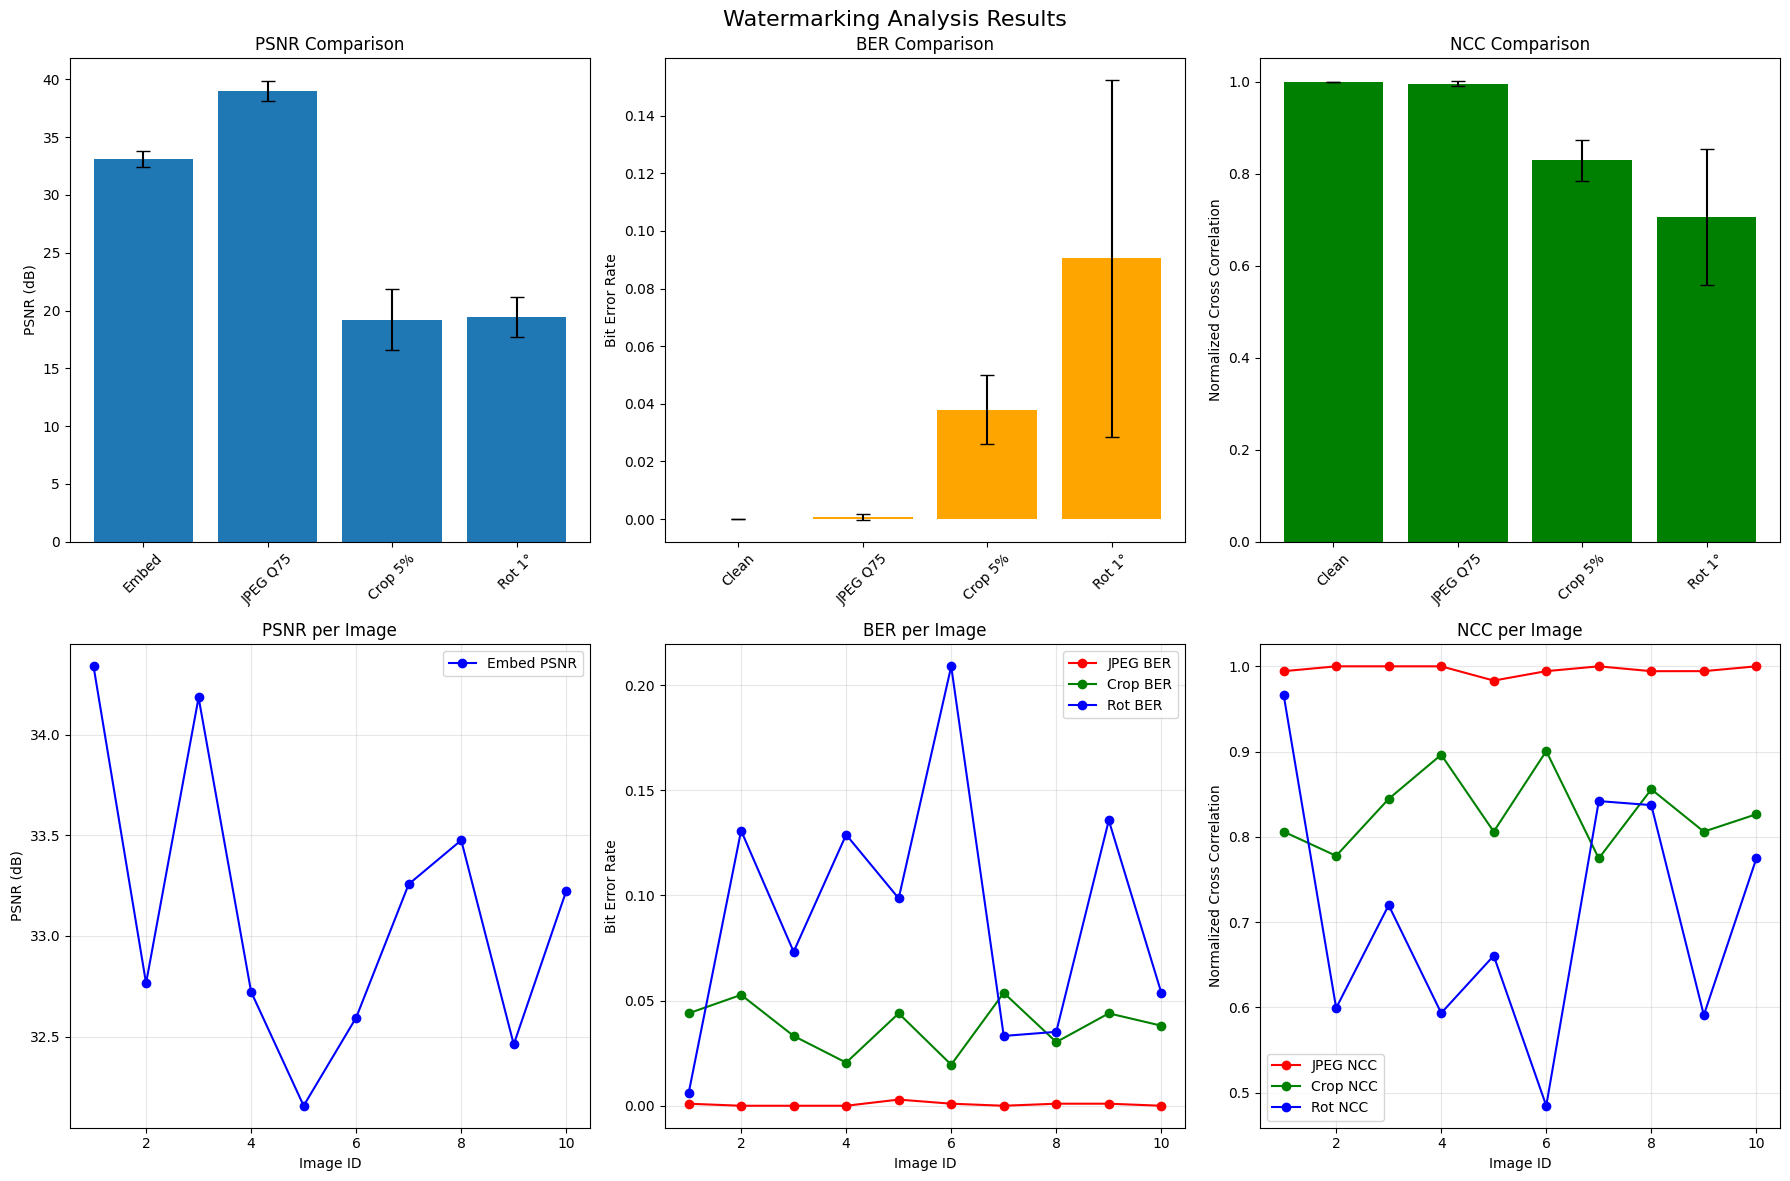


DETAILED RESULTS TABLE
ID  PSNR   C_BER  C_NCC  J_PSNR  J_BER  J_NCC  Cr_PSNR  Cr_BER  Cr_NCC  R_PSNR  R_BER  R_NCC 
------------------------------------------------------------------------------------------------------------------------
1   34.34  0.0000 1.000  39.20   0.0010 0.994  17.30    0.0439  0.806   18.01   0.0059 0.967 
2   32.77  0.0000 1.000  39.97   0.0000 1.000  19.26    0.0527  0.778   19.27   0.1309 0.599 
3   34.19  0.0000 1.000  38.85   0.0000 1.000  19.66    0.0332  0.845   19.81   0.0732 0.720 
4   32.72  0.0000 1.000  38.38   0.0000 1.000  23.04    0.0205  0.896   21.28   0.1289 0.593 
5   32.16  0.0000 1.000  40.00   0.0029 0.983  19.06    0.0439  0.806   22.15   0.0986 0.661 
6   32.59  0.0000 1.000  38.40   0.0010 0.994  22.53    0.0195  0.901   20.48   0.2090 0.485 
7   33.26  0.0000 1.000  38.17   0.0000 1.000  14.68    0.0537  0.775   18.89   0.0332 0.842 
8   33.48  0.0000 1.000  37.49   0.0010 0.994  21.06    0.0303  0.856   16.95   0.0352 0.837 
9   32.46

In [6]:
import watermarking, utilities, attacks, parameters
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os

# =========================
# Configuration
# =========================
HOST_IMAGES_PATH = "results/host/"
WATERMARK_PATH = "results/watermark_32x32.png"
OUTPUT_PATH = "results/analysis/"
NUM_IMAGES = 10

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_PATH, exist_ok=True)

# =========================
# Analysis Functions
# =========================
def run_single_image_analysis(image_idx):
    """Run complete analysis for a single image"""
    print(f"\n=== Analyzing Image {image_idx} ===")
    
    # Paths
    host_path = f"{HOST_IMAGES_PATH}image{image_idx}.jpg"
    watermarked_path = f"{OUTPUT_PATH}watermarked_{image_idx}.png"
    
    # Check if host image exists
    if not os.path.exists(host_path):
        print(f"Host image {host_path} not found!")
        return None
    
    try:
        # 1. Load host image and watermark
        host_pil = Image.open(host_path).convert("RGB")
        watermark_pil = Image.open(WATERMARK_PATH).convert("RGBA")
        
        # Convert host to YCbCr and get Y channel
        Y, Cb, Cr = utilities.to_ycbcr_arrays(host_pil)
        
        # Prepare watermark bits
        wm_bits_true = utilities.prepare_watermark_bits(watermark_pil, parameters.WATERMARK_SIZE)
        
        # Embed watermark
        Y_wm = watermarking.embed_watermark(Y, wm_bits_true)
        
        # Convert back to RGB and save
        watermarked_pil = utilities.from_ycbcr_arrays(Y_wm, Cb, Cr)
        watermarked_pil.save(watermarked_path)
        
        # Convert to numpy arrays for PSNR calculation
        host_u8 = np.array(host_pil, dtype=np.uint8)
        watermarked_u8 = np.array(watermarked_pil, dtype=np.uint8)
        
        # Calculate PSNR for embedding
        psnr_embed = utilities.psnr(host_u8, watermarked_u8)
        
        # 2. Extract from clean watermarked image (baseline)
        bits_clean = watermarking.extract_watermark(Y_wm, parameters.WATERMARK_SIZE)
        ber_clean = utilities.bit_error_rate(wm_bits_true, bits_clean)
        ncc_clean = utilities.normalized_cross_correlation(wm_bits_true, bits_clean)
        
        results = {
            'image_id': image_idx,
            'psnr_embed': psnr_embed,
            'clean_ber': ber_clean,
            'clean_ncc': ncc_clean
        }
        
        # 3. JPEG Compression Attack (Q=75)
        jpeg_path = f"{OUTPUT_PATH}attacked_jpeg75_{image_idx}.jpg"
        attacks.jpeg_attack(watermarked_path, jpeg_path, quality=75)
        
        # Load attacked image and calculate PSNR
        jpeg_pil = Image.open(jpeg_path).convert("RGB")
        jpeg_u8 = np.array(jpeg_pil, dtype=np.uint8)
        psnr_jpeg = utilities.psnr(watermarked_u8, jpeg_u8)
        
        # Extract watermark from JPEG attacked image
        Y_jpeg, _, _ = utilities.to_ycbcr_arrays(jpeg_pil)
        bits_jpeg = watermarking.extract_watermark(Y_jpeg, parameters.WATERMARK_SIZE)
        ber_jpeg = utilities.bit_error_rate(wm_bits_true, bits_jpeg)
        ncc_jpeg = utilities.normalized_cross_correlation(wm_bits_true, bits_jpeg)

        results.update({
            'jpeg_psnr': psnr_jpeg,
            'jpeg_ber': ber_jpeg,
            'jpeg_ncc': ncc_jpeg
        })
        
        # 4. Cropping Attack (1 patch, 5% area)
        crop_path = f"{OUTPUT_PATH}attacked_crop_{image_idx}.png"
        
        # Apply crop attack using numpy array
        crop_u8 = watermarked_u8.copy()
        attacks.crop_attack(crop_u8, area_ratio=0.05, num_patches=1, seed=42)
        crop_pil = Image.fromarray(crop_u8)
        crop_pil.save(crop_path)
        
        # Calculate PSNR for crop attack
        psnr_crop = utilities.psnr(watermarked_u8, crop_u8)
        
        # Extract watermark from cropped image
        Y_crop, _, _ = utilities.to_ycbcr_arrays(crop_pil)
        bits_crop = watermarking.extract_watermark(Y_crop, parameters.WATERMARK_SIZE)
        ber_crop = utilities.bit_error_rate(wm_bits_true, bits_crop)
        ncc_crop = utilities.normalized_cross_correlation(wm_bits_true, bits_crop)

        results.update({
            'crop_psnr': psnr_crop,
            'crop_ber': ber_crop,
            'crop_ncc': ncc_crop
        })
        
        # 5. Rotation Attack (1 degree)
        rot_path = f"{OUTPUT_PATH}attacked_rot1_{image_idx}.png"
        rot_pil = attacks.rotation_attack(watermarked_pil, angle=1.0)
        rot_pil.save(rot_path)
        
        # Load attacked image and calculate PSNR
        rot_u8 = np.array(rot_pil, dtype=np.uint8)
        psnr_rot = utilities.psnr(watermarked_u8, rot_u8)
        
        # Extract watermark with rotation compensation
        Y_rot, _, _ = utilities.to_ycbcr_arrays(rot_pil)
        bits_rot = watermarking.extract_watermark_enhanced(Y_rot, parameters.WATERMARK_SIZE)
        ber_rot = utilities.bit_error_rate(wm_bits_true, bits_rot)
        ncc_rot = utilities.normalized_cross_correlation(wm_bits_true, bits_rot)

        results.update({
            'rot_psnr': psnr_rot,
            'rot_ber': ber_rot,
            'rot_ncc': ncc_rot
        })
        
        print(f"Image {image_idx} analysis completed successfully")
        return results
        
    except Exception as e:
        print(f"Error processing image {image_idx}: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

# =========================
# Main Analysis Loop
# =========================
print("Starting Watermarking Analysis...")
print(f"Host images: {HOST_IMAGES_PATH}image1.jpg to image{NUM_IMAGES}.jpg")
print(f"Watermark: {WATERMARK_PATH}")
print(f"Output directory: {OUTPUT_PATH}")

# Collect results for all images
all_results = []
for i in range(1, NUM_IMAGES + 1):
    result = run_single_image_analysis(i)
    if result is not None:
        all_results.append(result)

# =========================
# Results Analysis and Visualization
# =========================
if all_results:
    # Convert to DataFrame for easier analysis
    df = pd.DataFrame(all_results)
    
    # Save detailed results to CSV
    df.to_csv(f"{OUTPUT_PATH}detailed_results.csv", index=False)
    
    # Calculate statistics
    stats = {
        'Metric': ['PSNR Embed', 'Clean BER', 'Clean NCC', 
                  'JPEG PSNR', 'JPEG BER', 'JPEG NCC',
                  'Crop PSNR', 'Crop BER', 'Crop NCC',
                  'Rot PSNR', 'Rot BER', 'Rot NCC'],
        'Mean': [
            df['psnr_embed'].mean(), df['clean_ber'].mean(), df['clean_ncc'].mean(),
            df['jpeg_psnr'].mean(), df['jpeg_ber'].mean(), df['jpeg_ncc'].mean(),
            df['crop_psnr'].mean(), df['crop_ber'].mean(), df['crop_ncc'].mean(),
            df['rot_psnr'].mean(), df['rot_ber'].mean(), df['rot_ncc'].mean()
        ],
        'Std': [
            df['psnr_embed'].std(), df['clean_ber'].std(), df['clean_ncc'].std(),
            df['jpeg_psnr'].std(), df['jpeg_ber'].std(), df['jpeg_ncc'].std(),
            df['crop_psnr'].std(), df['crop_ber'].std(), df['crop_ncc'].std(),
            df['rot_psnr'].std(), df['rot_ber'].std(), df['rot_ncc'].std()
        ],
        'Min': [
            df['psnr_embed'].min(), df['clean_ber'].min(), df['clean_ncc'].min(),
            df['jpeg_psnr'].min(), df['jpeg_ber'].min(), df['jpeg_ncc'].min(),
            df['crop_psnr'].min(), df['crop_ber'].min(), df['crop_ncc'].min(),
            df['rot_psnr'].min(), df['rot_ber'].min(), df['rot_ncc'].min()
        ],
        'Max': [
            df['psnr_embed'].max(), df['clean_ber'].max(), df['clean_ncc'].max(),
            df['jpeg_psnr'].max(), df['jpeg_ber'].max(), df['jpeg_ncc'].max(),
            df['crop_psnr'].max(), df['crop_ber'].max(), df['crop_ncc'].max(),
            df['rot_psnr'].max(), df['rot_ber'].max(), df['rot_ncc'].max()
        ]
    }
    
    stats_df = pd.DataFrame(stats)
    stats_df.to_csv(f"{OUTPUT_PATH}summary_statistics.csv", index=False)
    
    # Print summary
    print("\n" + "="*60)
    print("WATERMARKING ANALYSIS SUMMARY")
    print("="*60)
    print(f"Number of successfully processed images: {len(all_results)}")
    print(f"\nEmbedding Quality (PSNR): {df['psnr_embed'].mean():.2f} ± {df['psnr_embed'].std():.2f} dB")
    print(f"Clean Extraction BER: {df['clean_ber'].mean():.4f} ± {df['clean_ber'].std():.4f}")
    print(f"Clean Extraction NCC: {df['clean_ncc'].mean():.4f} ± {df['clean_ncc'].std():.4f}")
    
    print(f"\nJPEG Q75 Attack:")
    print(f"  PSNR: {df['jpeg_psnr'].mean():.2f} ± {df['jpeg_psnr'].std():.2f} dB")
    print(f"  BER:  {df['jpeg_ber'].mean():.4f} ± {df['jpeg_ber'].std():.4f}")
    print(f"  NCC:  {df['jpeg_ncc'].mean():.4f} ± {df['jpeg_ncc'].std():.4f}")
    
    print(f"\nCropping Attack (5% area):")
    print(f"  PSNR: {df['crop_psnr'].mean():.2f} ± {df['crop_psnr'].std():.2f} dB")
    print(f"  BER:  {df['crop_ber'].mean():.4f} ± {df['crop_ber'].std():.4f}")
    print(f"  NCC:  {df['crop_ncc'].mean():.4f} ± {df['crop_ncc'].std():.4f}")
    
    print(f"\nRotation Attack (1°):")
    print(f"  PSNR: {df['rot_psnr'].mean():.2f} ± {df['rot_psnr'].std():.2f} dB")
    print(f"  BER:  {df['rot_ber'].mean():.4f} ± {df['rot_ber'].std():.4f}")
    print(f"  NCC:  {df['rot_ncc'].mean():.4f} ± {df['rot_ncc'].std():.4f}")
    
    # Create visualizations
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Watermarking Analysis Results', fontsize=16)
    
    # PSNR comparison
    attacks_psnr = ['Embed', 'JPEG Q75', 'Crop 5%', 'Rot 1°']
    psnr_means = [df['psnr_embed'].mean(), df['jpeg_psnr'].mean(), 
                  df['crop_psnr'].mean(), df['rot_psnr'].mean()]
    psnr_stds = [df['psnr_embed'].std(), df['jpeg_psnr'].std(),
                 df['crop_psnr'].std(), df['rot_psnr'].std()]
    
    axes[0,0].bar(attacks_psnr, psnr_means, yerr=psnr_stds, capsize=5)
    axes[0,0].set_title('PSNR Comparison')
    axes[0,0].set_ylabel('PSNR (dB)')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # BER comparison
    attacks_ber = ['Clean', 'JPEG Q75', 'Crop 5%', 'Rot 1°']
    ber_means = [df['clean_ber'].mean(), df['jpeg_ber'].mean(),
                 df['crop_ber'].mean(), df['rot_ber'].mean()]
    ber_stds = [df['clean_ber'].std(), df['jpeg_ber'].std(),
                df['crop_ber'].std(), df['rot_ber'].std()]
    
    axes[0,1].bar(attacks_ber, ber_means, yerr=ber_stds, capsize=5, color='orange')
    axes[0,1].set_title('BER Comparison')
    axes[0,1].set_ylabel('Bit Error Rate')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # NCC comparison
    ncc_means = [df['clean_ncc'].mean(), df['jpeg_ncc'].mean(),
                 df['crop_ncc'].mean(), df['rot_ncc'].mean()]
    ncc_stds = [df['clean_ncc'].std(), df['jpeg_ncc'].std(),
                df['crop_ncc'].std(), df['rot_ncc'].std()]
    
    axes[0,2].bar(attacks_ber, ncc_means, yerr=ncc_stds, capsize=5, color='green')
    axes[0,2].set_title('NCC Comparison')
    axes[0,2].set_ylabel('Normalized Cross Correlation')
    axes[0,2].tick_params(axis='x', rotation=45)
    
    # Individual image results
    x = range(1, len(all_results) + 1)
    axes[1,0].plot(x, df['psnr_embed'], 'bo-', label='Embed PSNR')
    axes[1,0].set_title('PSNR per Image')
    axes[1,0].set_xlabel('Image ID')
    axes[1,0].set_ylabel('PSNR (dB)')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    axes[1,1].plot(x, df['jpeg_ber'], 'ro-', label='JPEG BER')
    axes[1,1].plot(x, df['crop_ber'], 'go-', label='Crop BER')
    axes[1,1].plot(x, df['rot_ber'], 'bo-', label='Rot BER')
    axes[1,1].set_title('BER per Image')
    axes[1,1].set_xlabel('Image ID')
    axes[1,1].set_ylabel('Bit Error Rate')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    axes[1,2].plot(x, df['jpeg_ncc'], 'ro-', label='JPEG NCC')
    axes[1,2].plot(x, df['crop_ncc'], 'go-', label='Crop NCC')
    axes[1,2].plot(x, df['rot_ncc'], 'bo-', label='Rot NCC')
    axes[1,2].set_title('NCC per Image')
    axes[1,2].set_xlabel('Image ID')
    axes[1,2].set_ylabel('Normalized Cross Correlation')
    axes[1,2].legend()
    axes[1,2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_PATH}analysis_results.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print detailed results table
    print("\n" + "="*120)
    print("DETAILED RESULTS TABLE")
    print("="*120)
    print(f"{'ID':<3} {'PSNR':<6} {'C_BER':<6} {'C_NCC':<6} {'J_PSNR':<7} {'J_BER':<6} {'J_NCC':<6} {'Cr_PSNR':<8} {'Cr_BER':<7} {'Cr_NCC':<7} {'R_PSNR':<7} {'R_BER':<6} {'R_NCC':<6}")
    print("-" * 120)
    for _, row in df.iterrows():
        print(f"{int(row['image_id']):<3} {row['psnr_embed']:<6.2f} {row['clean_ber']:<6.4f} {row['clean_ncc']:<6.3f} "
              f"{row['jpeg_psnr']:<7.2f} {row['jpeg_ber']:<6.4f} {row['jpeg_ncc']:<6.3f} "
              f"{row['crop_psnr']:<8.2f} {row['crop_ber']:<7.4f} {row['crop_ncc']:<7.3f} "
              f"{row['rot_psnr']:<7.2f} {row['rot_ber']:<6.4f} {row['rot_ncc']:<6.3f}")
    
    print(f"\nResults saved to: {OUTPUT_PATH}")
    print("Files generated:")
    print("- detailed_results.csv: Raw data for all images")
    print("- summary_statistics.csv: Statistical summary")
    print("- analysis_results.png: Visualization plots")
    
else:
    print("No images were successfully processed. Please check your file paths and image files.")